In [1]:
from __future__ import print_function
from __future__ import division

In [2]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

In [3]:
from IPython.display import Image

In [4]:
import numpy as np
from astropy.table import Table
from scipy.stats import binned_statistic, scoreatpercentile

In [5]:
cd ../Debiasing_codes/

/Users/spb/Work/projects/GalaxyZoo/Ross/Debiasing-testing/Debiasing_codes


In [6]:
arm_question='t11_arms_number'
arm_answers=('a31_1', 'a32_2', 'a33_3', 'a34_4',
             'a36_more_than_4', 'a37_cant_tell')
arm_answerlabels = ('1 arm', '2 arms', '3 arms',
                    '4 arms', '5+ arms', '?? arms')

In [7]:
source_dir = "../../fits/"

data_vl = Table.read(source_dir + 'data_vl.fits')
debiased_vl = Table.read(source_dir + 'debiased_vl_{}.fits'.format(arm_question))

In [8]:
def morph_assignment(table, threshold=0, redistribute=True,
                     redistribute_threshold=0.0,
                     cant_tell_threshold=0.8,
                     cant_tell_index=5,
                     question='t11_arms_number',
                     answers=('a31_1', 'a32_2', 'a33_3', 'a34_4',
                              'a36_more_than_4', 'a37_cant_tell')):

    morph_fv_cols = ['{}_{}_weighted_fraction'.format(question, a) 
                     for a in answers]

    # select fv with greatest vote fraction
    fv = np.array([table[c] for c in morph_fv_cols])
    morph = np.argmax(fv, axis=0)
    # mask elements that do not meet the threshold
    maxfv = fv[morph].diagonal()
    np.putmask(morph, maxfv < threshold, -1)
    
    if redistribute is True:
        # redistribute iff selected as cant_tell
        redist = morph == cant_tell_index
        # but fv_cant_tell is above cant_tell_threshold
        redist &= maxfv < cant_tell_threshold
        # then select greatest vote fraction from remainding questions
        fv = np.array([f for i, f in enumerate(fv[:, redist])
                       if i != cant_tell_index])
        redist_morph = np.argmax(fv, axis=0)
        # mask elements that do not meet the threshold
        maxfv = fv[redist_morph].diagonal()
        sumfv = fv.sum(axis=0)
        np.putmask(redist_morph, maxfv < redistribute_threshold, -1)
        morph[redist] = redist_morph
            
    return morph

In [9]:
def bin_by_column(column, nbins, fixedcount=True):
    sorted_indices = np.argsort(column)
    if fixedcount:
        bin_edges = np.linspace(0, 1, nbins + 1)
        bin_edges[-1] += 1
        values = np.empty(len(column))
        values[sorted_indices] = np.linspace(0, 1, len(column))
        bins = np.digitize(values, bins=bin_edges)
    else:
        bin_edges = np.linspace(np.min(column),np.max(column), nbins + 1)
        bin_edges[-1] += 1
        values = column
        bins = np.digitize(values, bins=bin_edges)
    x, b, n = binned_statistic(values, column, bins=bin_edges)
    return x, bins

In [10]:
import scipy.stats.distributions as dist

def frac_errors(k, n, c=0.683):
    # Gets the errors according to the Cameron et al. paper.
    
    # cope with both array and individual value inputs
    k = np.array(k, np.float, ndmin=1)
    frac = k / n
    low = dist.beta.ppf((1-c)/2., k+1, n-k+1)
    high = dist.beta.ppf(1-(1-c)/2., k+1, n-k+1)    
    # ensure confidence intervals are sensible for
    # extreme fractions
    low = np.where(frac < low, 0.0, low)
    high = np.where(frac > high, 1.0, high)
    # return sensible shaped arrays
    out = Table((frac, low, high), names=('frac', 'low', 'high'))
    return out

In [11]:
def binned_morph_frac(morph, bins):
    total = np.bincount(bins)[1:]
    frac = []
    for m in np.unique(morph):
        count = np.bincount(bins[morph == m], minlength=bins.max()+1)[1:]
        frac.append(frac_errors(count, total))
    return frac

In [12]:
def plot_morph_frac_trend(x, frac, frac_raw=None, xlabel='redshift', answerlabels=None):
    C = ["purple","red","magenta","green","blue","orange"]
    nmorph = len(frac)
    fig, axarr = plt.subplots(nmorph, 1, sharex=True, sharey=False, figsize=(10, 3*nmorph))    
    for m in range(nmorph):
        ax = axarr[m]
        ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=4, prune="upper"))
        if frac_raw is not None:
            ax.plot(x, frac_raw[m]['frac'], '--', color=C[m], lw=2, alpha=0.5)
            ax.fill_between(x, frac_raw[m]['low'], frac_raw[m]['high'], color=C[m], alpha=0.25)
        mean = frac[m]['frac'].mean()
        ax.hlines([mean], x.min(), x.max(), linestyle=':', color=C[m], lw=2)
        ax.plot(x, frac[m]['frac'], color=C[m], lw=2)
        ax.fill_between(x, frac[m]['low'], frac[m]['high'], color=C[m], alpha=0.5)
        ax.set_ylabel('fraction')
        if answerlabels is not None:
            ax.text(0.05, 0.95, answerlabels[m], transform=ax.transAxes, va='top')
    ax.set_xlabel(xlabel)
    plt.subplots_adjust(hspace=0)

In [13]:
morph_raw = morph_assignment(data_vl, threshold=0, redistribute=True,
                         redistribute_threshold=0.0,
                         cant_tell_threshold=0.8,
                         cant_tell_index=5,
                         question=arm_question,
                         answers=arm_answers)

morph = morph_assignment(debiased_vl, threshold=0, redistribute=True,
                         redistribute_threshold=0.0,
                         cant_tell_threshold=0.8,
                         cant_tell_index=5,
                         question=arm_question,
                         answers=arm_answers)

morph_no_redistrib = morph_assignment(debiased_vl, threshold=0, redistribute=False,
                         question=arm_question,
                         answers=arm_answers)

In [14]:
redshift = data_vl['REDSHIFT_1']
zbin, bins = bin_by_column(redshift, nbins=20, fixedcount=True)

In [15]:
frac = binned_morph_frac(morph, bins)
frac_raw = binned_morph_frac(morph_raw, bins)
frac_no_redistrib = binned_morph_frac(morph_no_redistrib, bins)

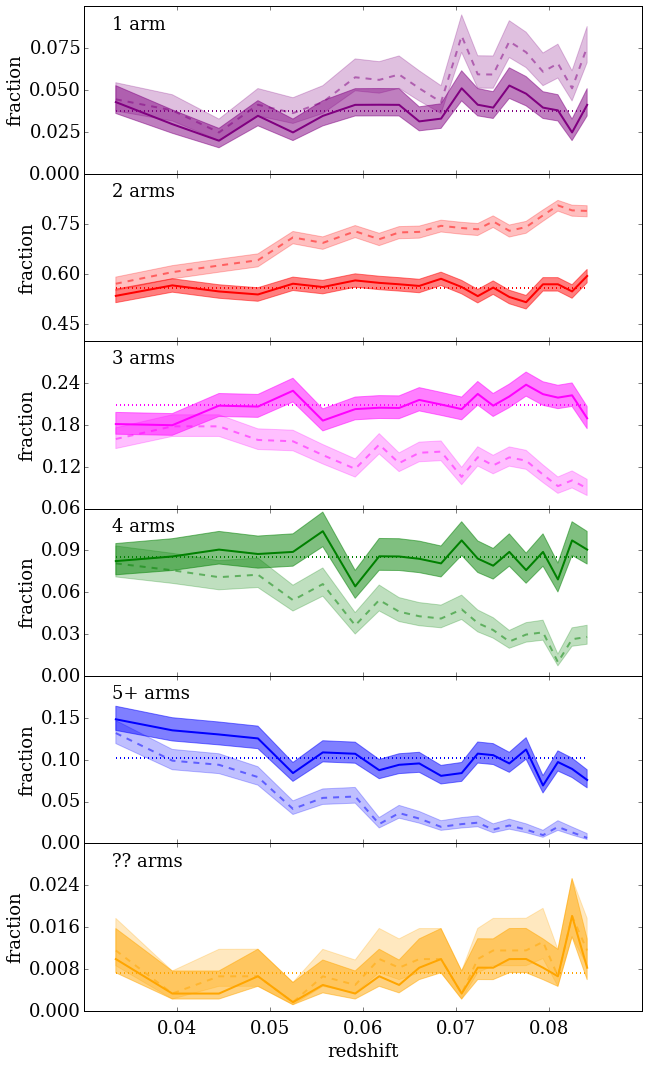

In [16]:
plot_morph_frac_trend(zbin, frac, frac_raw, 'redshift', arm_answerlabels)

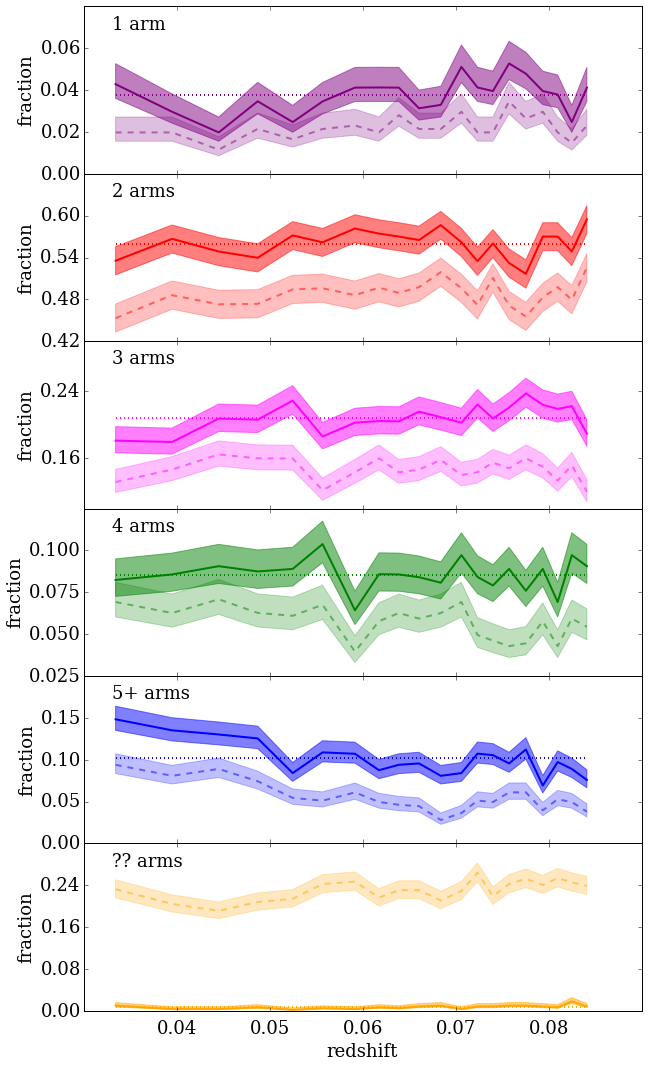

In [17]:
plot_morph_frac_trend(zbin, frac, frac_no_redistrib, 'redshift', arm_answerlabels)

In [18]:
def plot_debiased_distrib(data, debiased,
                  question='t11_arms_number',
                  answers=('a31_1', 'a32_2', 'a33_3', 'a34_4',
                           'a36_more_than_4', 'a37_cant_tell'),
                  answerlabels=('1 arm', '2 arms', '3 arms',
                                '4 arms', '5+ arms', '?? arms')):
    # Plot debiased values vs. raw values for comparison. Blue -> red with z.

    C = ["purple","red","magenta","green","blue","orange"]
    
    morph_fv_cols = ['{}_{}_weighted_fraction'.format(question, a) 
                     for a in answers]

    fig, axarr = plt.subplots(2, 3, sharex=True, sharey=True)

    z = data['REDSHIFT_1']
    z_low = (z > 0.03) & (z < 0.05)
    d_low = data[z_low]
    z_high = (z > 0.07) & (z < 0.085)
    d_high = data[z_high]

    for m, fv_col in enumerate(morph_fv_cols):
        ax = axarr.ravel()[m]
        y, bins, n = ax.hist(d_low[fv_col], histtype='step', log=True,
                             lw=8, alpha=0.3, normed=True, bins=5, color=C[m])
        ax.hist(d_high[fv_col], histtype='step', ls='dotted', lw=4,
                bins=bins, normed=True, color=C[m])
        #ax.hist(debiased[z_low][fv_col], histtype='step', bins=bins, normed=True, color=C[m])
        ax.hist(debiased[z_high][fv_col], histtype='step', ls='dashed',
                lw=2, bins=bins, normed=True, color=C[m])
        ax.text(0.5, 0.9, answerlabels[m], fontsize='small',
                transform=ax.transAxes, va='top', ha='left')
        
        #ax.semilogx()

        if m > 2:
            ax.set_xlabel(r"$f_v$")
        if m == 0 or m == 3:
            ax.set_ylabel(r"fraction")

    plt.axis((0, 1, 0.011, 10))
            
    fig.subplots_adjust(hspace=0, wspace=0)

    fig.savefig('plots/debiased_distrib.pdf')

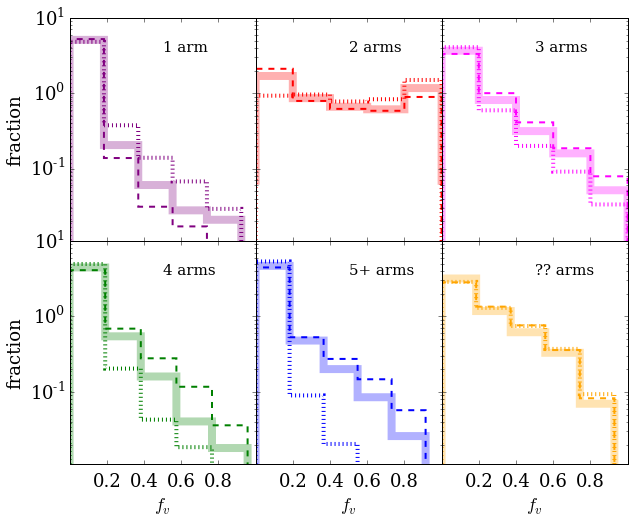

In [19]:
plot_debiased_distrib(data_vl, debiased_vl,
              question=arm_question,
              answers=arm_answers,
              answerlabels=arm_answerlabels)

In [20]:
def plot_distrib_by_morph(morph, x, bins=20, xlabel='',
                          answerlabels=('1 arm', '2 arms', '3 arms',
                                        '4 arms', '5+ arms', '?? arms'),
                          multipanel=True,
                         **kwargs):
    # Plot debiased values vs. raw values for comparison. Blue -> red with z.

    C = ["purple","red","magenta","green","blue","orange"]
    
    unique_morph = np.unique(morph)
    nmorph = len(unique_morph)
    nrows = (nmorph + 1) // 3
    
    x = np.array(x, ndmin=2)
    
    if multipanel:
        fig, axarr = plt.subplots(nrows, 3, sharex=True, sharey=True)
    else:
        fig, ax = plt.subplots()

        
    for m in unique_morph:
        if multipanel:
            ax = axarr.ravel()[m]
        xm = x[:, morph == m]
        if multipanel:
            for xc in x:
                y, bins, n = ax.hist(xc, histtype='step', lw=2, alpha=0.8,
                                     bins=bins, color='k',
                                     label='all',
                                     **kwargs)

        for xmc in xm:
            y, bins, n = ax.hist(xmc, histtype='step', lw=2, alpha=0.8,
                                 bins=bins, color=C[m],
                                 label=answerlabels[m],
                                 **kwargs)

        if not multipanel:
            bins = bins + 0.1*(bins[1]-bins[0])
            
        if multipanel:
            ax.text(0.5, 0.9, answerlabels[m], fontsize='small',
                    transform=ax.transAxes, va='top', ha='left')
            if m // 3 == nrows - 1 :
                ax.set_xlabel(xlabel)
            if m % 3 == 0:
                ax.set_ylabel("fraction")

    ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=4, prune="both"))
    if not multipanel:
        plt.legend()
    fig.subplots_adjust(hspace=0, wspace=0)

In [21]:
stellar_mass = data_vl['LOGMSTAR_BALDRY06']
mbin, bins = bin_by_column(stellar_mass, nbins=20, fixedcount=True)
mfrac = binned_morph_frac(morph, bins)

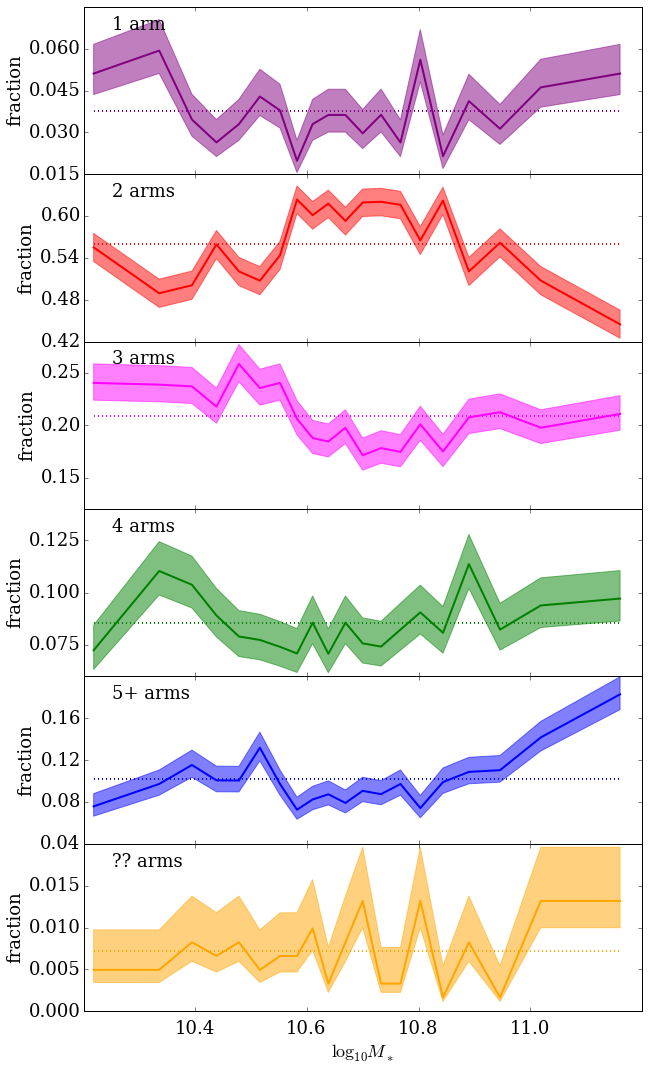

In [22]:
plot_morph_frac_trend(mbin, mfrac, None, '$\log_{10}{M_*}$', arm_answerlabels)

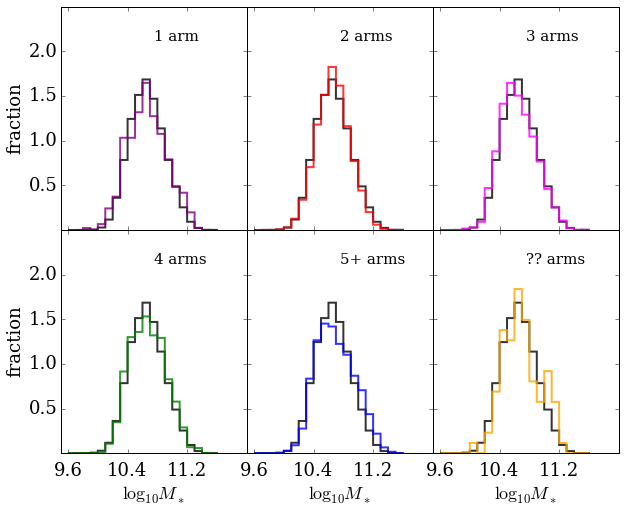

In [23]:
plot_distrib_by_morph(morph, stellar_mass, 20, '$\log_{10}{M_*}$', arm_answerlabels,
                     normed=True, range=(9.6, 11.6), multipanel=True)
_ = plt.axis(ymax=2.5)

In [24]:
gr = data_vl['MG'] - data_vl['MR']
grbin, bins = bin_by_column(gr, nbins=20, fixedcount=True)
grfrac = binned_morph_frac(morph, bins)

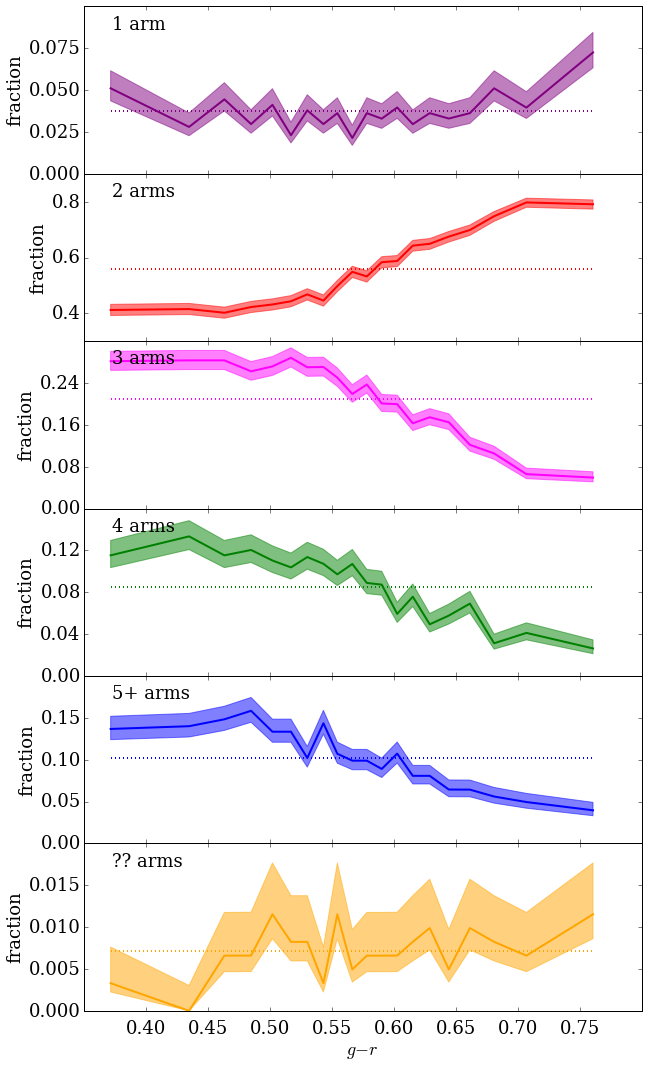

In [25]:
plot_morph_frac_trend(grbin, grfrac, None, '$g-r$', arm_answerlabels)

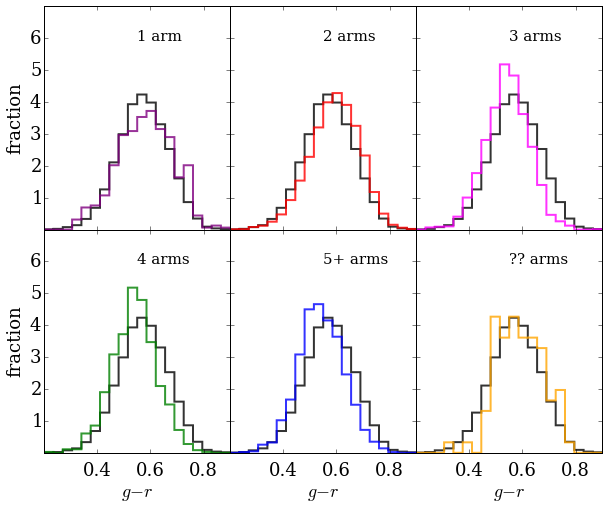

In [26]:
plot_distrib_by_morph(morph, gr, 20, '$g-r$', arm_answerlabels,
                     normed=True, range=(0.2, 0.9))
_ = plt.axis(ymax = 7.0)

In [27]:
ri = data_vl['MR'] - data_vl['MI']
ribin, bins = bin_by_column(ri, nbins=20, fixedcount=True)
rifrac = binned_morph_frac(morph, bins)

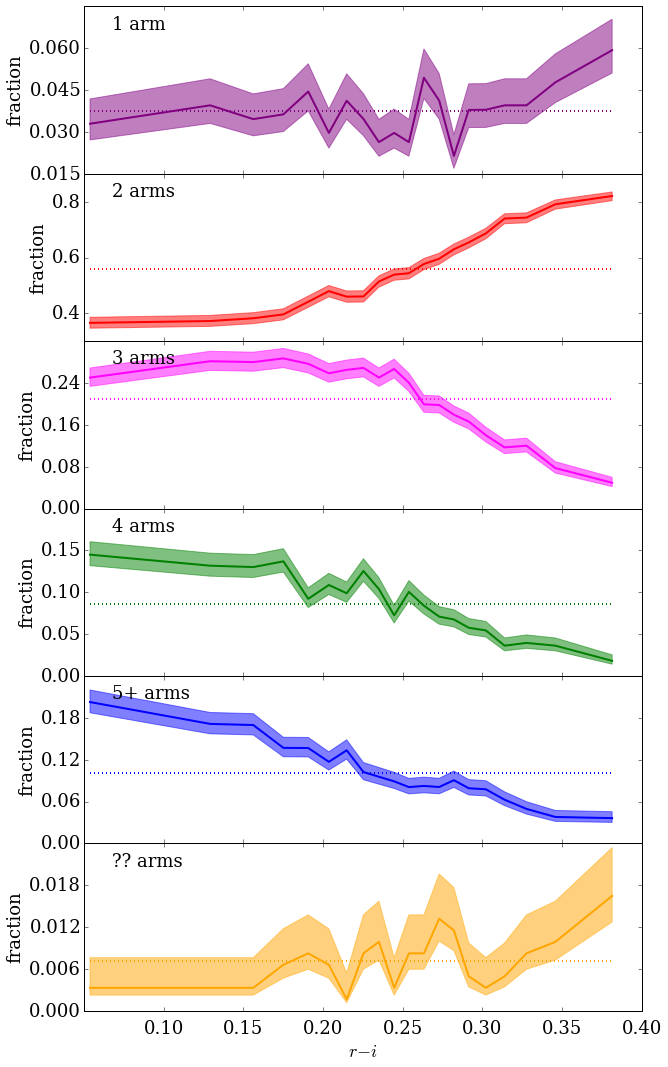

In [28]:
plot_morph_frac_trend(ribin, rifrac, None, '$r-i$', arm_answerlabels)

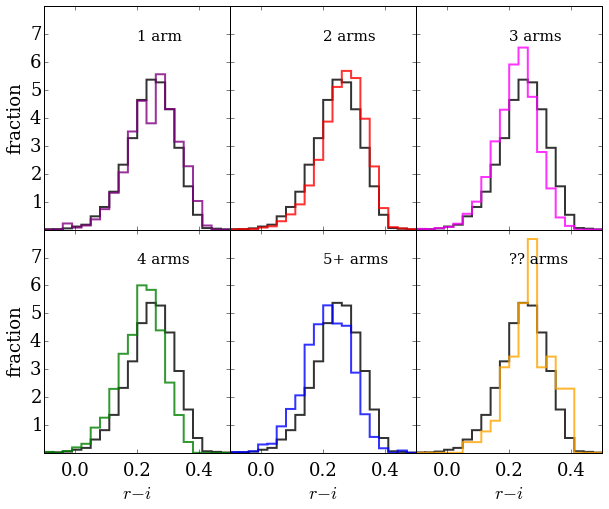

In [29]:
plot_distrib_by_morph(morph, ri, 20, '$r-i$', arm_answerlabels,
                     normed=True, range=(-0.1, 0.5))
_ = plt.axis(ymax = 8.0)